# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.1)
plt.rcParams['font.family'] = 'StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Loading The Dataset From The Official Website

In [2]:
column_names = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
try:
    iris_df = pd.read_csv("iris_dataset.csv", index_col=None)
except FileNotFoundError as err:
    iris_df = pd.read_csv(url, names=column_names)
    iris_df['species'] = iris_df['species'].str.slice(len('Iris-'),).str.capitalize()    
    iris_df.to_csv("iris_dataset.csv", index=False)

# Initial Exploratory Data Analysis (EAD)

## Simple Statistics

In [3]:
iris_df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [4]:
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Simple Plotting Of Properties

Pair plots of the properties can give us intuition about which pairs of variables might be important. Fundamentally, the Iris dataset is a toy-dataset for a classification problem where the goal/target is to get the correct Iris species. Therefore, as we plot the different measurements in pairs, coloring by the species is an effective strategy for getting a sense of which pairs of measurements could be used for _predicting_ the species of a new flower.

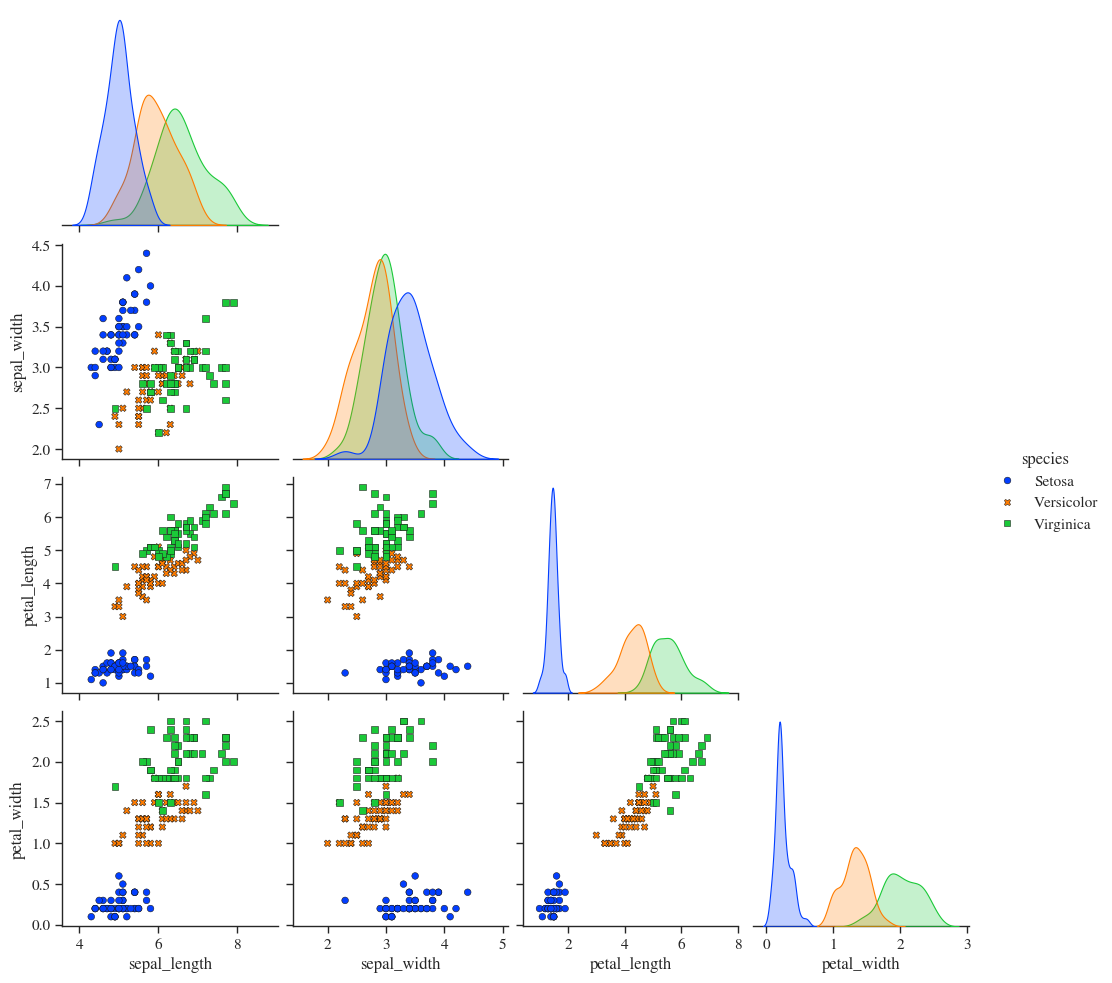

In [5]:
flower_properties = [a_prop for a_prop in iris_df.columns if 'species' not in a_prop]
with sns.plotting_context('paper', font_scale=1.25):
    pairGrid = sns.pairplot(data=iris_df, vars=flower_properties, hue='species', 
                            diag_kind='kde', corner=True, kind='scatter',
                            markers=['o', 'X', 's'], plot_kws=dict(ec='k'), palette='bright')
    plt.show()

Firstly, we can inspect the individual measurements themselves as we go down the diagonal. `sepal_length` and `sepal_width` have largely overlapping distributions, and could therefore not be used. While `petal_length` or `petal_width` could be used to reliably discriminate between Sertosa and the other two, the overlap of the tails of the distributions would make them inaccurate for Versicolor and Virginica. Moving on to pairs, we can see that the combination of `sepal_length` and `sepal_width` is not the best at discriminating between the different species, and this is consistent with the individual measurements as well. `petal_length` and `petal_width` generate fairly non-overlapping clusters, and therefore more traditional ML techniques

# K-Means Clustering And Gaussian Mixture Models

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## Preprocessing Data

In [7]:
label_encoder = LabelEncoder()
iris_species_encoded = label_encoder.fit_transform(iris_df['species'].to_numpy())

In [8]:
iris_features = iris_df[flower_properties]#.to_numpy()
iris_features_zscored = sp.stats.zscore(iris_features, axis=0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(iris_features_zscored, iris_species_encoded, test_size=0.2, random_state=40, shuffle=True)

## Performing A K-Means Clustering

In [10]:
kmeans_obj = KMeans(n_clusters=3, n_init=20).fit(X_train)
y_train_pred_kmeans = kmeans_obj.predict(X_train)

In [11]:
Xy_train_kmeans = X_train.copy()
Xy_train_kmeans['clus_lab']=y_train_pred_kmeans
Xy_train_kmeans['species']=y_train

y_test_pred_kmeans = kmeans_obj.predict(X_test)
Xy_test_kmeans = X_test.copy()
Xy_test_kmeans['clus_lab']=y_test_pred_kmeans
Xy_test_kmeans['species']=y_test

### Visualization Of Results

#### Simple Pair Plot

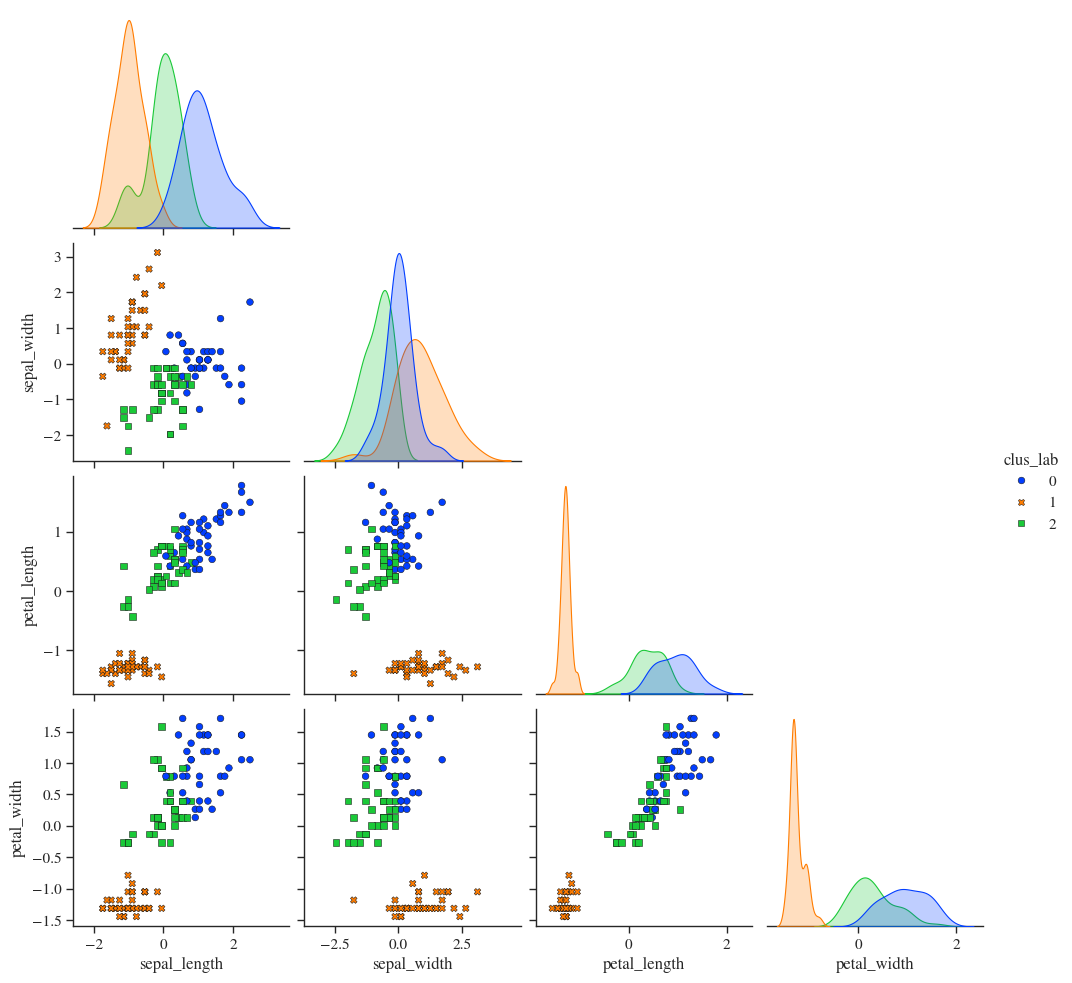

In [12]:
with sns.plotting_context('paper', font_scale=1.25):
    pairGrid = sns.pairplot(data=Xy_train_kmeans, vars=flower_properties, hue='clus_lab', 
                            diag_kind='kde', corner=True, kind='scatter',
                            markers=['o', 'X', 's'], plot_kws=dict(ec='k'), palette='bright')
    plt.show()

<a id="kmeansscatter"></a> 

#### Scatter Plot

In [13]:
def gen_label_colors(in_labels: np.ndarray, colors = None) -> np.ndarray:
    out_colors = np.empty_like(in_labels, dtype=object)
    def_colors = ['blue', 'red', 'green']
    if colors is None:
        iter_colors = def_colors
    else:
        iter_colors = colors
    for cID, color in enumerate(iter_colors):
        out_colors[in_labels==cID] = color
    return np.asarray(out_colors)


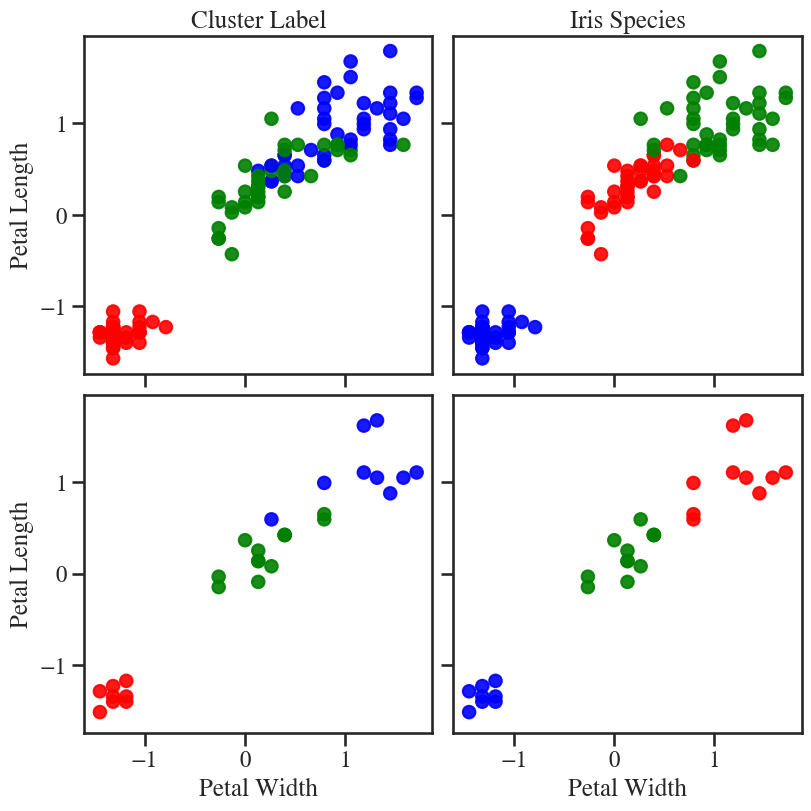

In [14]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(2,2, figsize=[8,8], sharey=True, sharex=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    fAx[0].scatter(Xy_train_kmeans['petal_width'], Xy_train_kmeans['petal_length'], c=gen_label_colors(Xy_train_kmeans['clus_lab']), alpha=0.9)
    fAx[1].scatter(Xy_train_kmeans['petal_width'], Xy_train_kmeans['petal_length'], c=gen_label_colors(Xy_train_kmeans['species']), alpha=0.9)
    
    fAx[2].scatter(Xy_test_kmeans['petal_width'], Xy_test_kmeans['petal_length'], c=gen_label_colors(Xy_test_kmeans['clus_lab']), alpha=0.9)
    fAx[3].scatter(Xy_test_kmeans['petal_width'], Xy_test_kmeans['petal_length'], c=gen_label_colors(Xy_test_kmeans['species'], colors=['blue', 'green', 'red']), alpha=0.9)
    
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    fAx[0].set_title('Cluster Label')
    fAx[1].set_title('Iris Species')
    [ax.set_xlabel(r'Petal Width') for ax in myAx[-1]]
    [ax.set_ylabel(r'Petal Length') for ax in myAx[:,0]]
    plt.show()

## Performing a Gaussian Mixtures Model

In [15]:
gmm_obj = GaussianMixture(n_components=3, n_init=10, max_iter=1000, covariance_type='tied').fit(X_train)
y_train_pred_gmm = gmm_obj.predict(X_train)

In [16]:
Xy_train_gmm = X_train.copy()
Xy_train_gmm['clus_lab']=y_train_pred_gmm
Xy_train_gmm['species']=y_train

y_test_pred_gmm = gmm_obj.predict(X_test)
Xy_test_gmm = X_test.copy()
Xy_test_gmm['clus_lab']=y_test_pred_gmm
Xy_test_gmm['species']=y_test

### Visualizing Results
#### Pair Plot For Visualizing

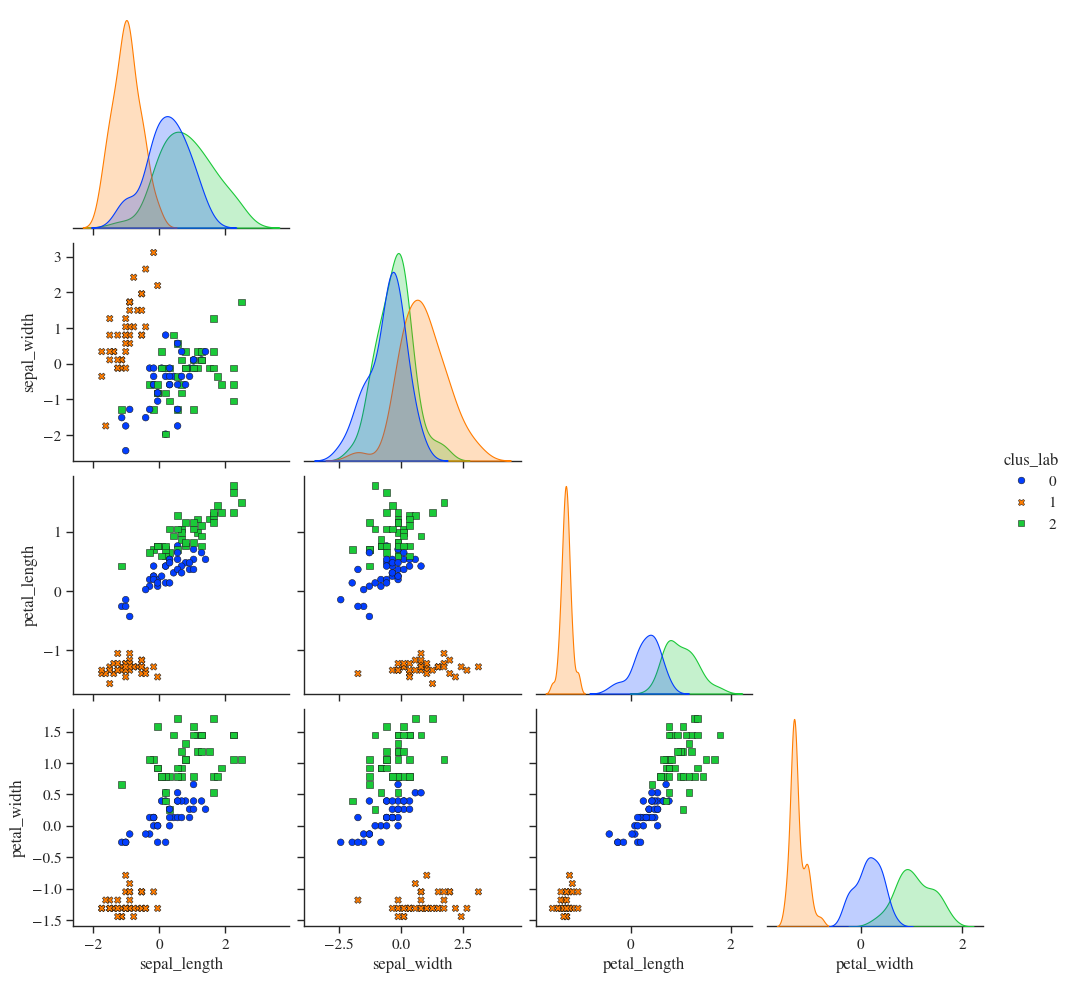

In [17]:
with sns.plotting_context('paper', font_scale=1.25):
    pairGrid = sns.pairplot(data=Xy_train_gmm, vars=flower_properties, hue='clus_lab', 
                            diag_kind='kde', corner=True, kind='scatter',
                            markers=['o', 'X', 's'], plot_kws=dict(ec='k'), palette='bright')
    plt.show()

#### Scatter Plots

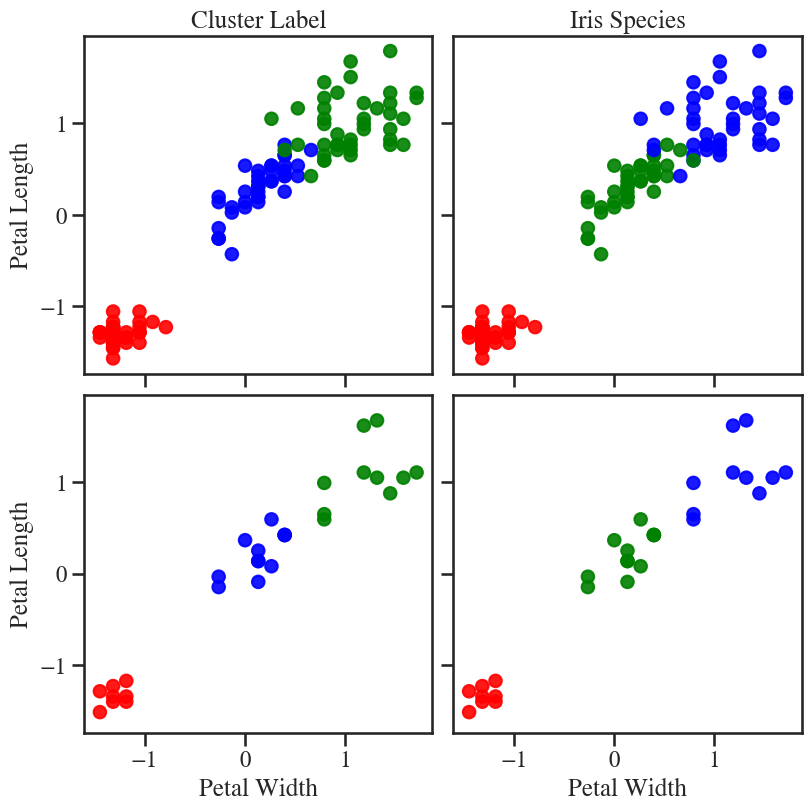

In [18]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(2,2, figsize=[8,8], sharey=True, sharex=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    fAx[0].scatter(Xy_train_gmm['petal_width'], Xy_train_gmm['petal_length'], c=gen_label_colors(Xy_train_gmm['clus_lab']), alpha=0.9)
    fAx[1].scatter(Xy_train_gmm['petal_width'], Xy_train_gmm['petal_length'], c=gen_label_colors(Xy_train_gmm['species'], colors=['red', 'green', 'blue']), alpha=0.9)
    
    fAx[2].scatter(Xy_test_gmm['petal_width'], Xy_test_gmm['petal_length'], c=gen_label_colors(Xy_test_gmm['clus_lab']), alpha=0.9)
    fAx[3].scatter(Xy_test_gmm['petal_width'], Xy_test_gmm['petal_length'], c=gen_label_colors(Xy_test_gmm['species'], colors=['red', 'green', 'blue']), alpha=0.9)
    
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    fAx[0].set_title('Cluster Label')
    fAx[1].set_title('Iris Species')
    [ax.set_xlabel(r'Petal Width') for ax in myAx[-1]]
    [ax.set_ylabel(r'Petal Length') for ax in myAx[:,0]]
    plt.show()

When compared to the KMeans <a href="kmeansscatter">scatter plot</a>, we can see that the GMM performs better. Since GMMs can be _elliptical_, they can more easily separate classes that might be at odd angles in a given feature space.

# Dimensionality Reduction Using PCA

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca_obj = PCA(whiten=True, svd_solver='full').fit(iris_df[flower_properties])

## Plotting The Explained Variance To See How Many PCs Are Needed

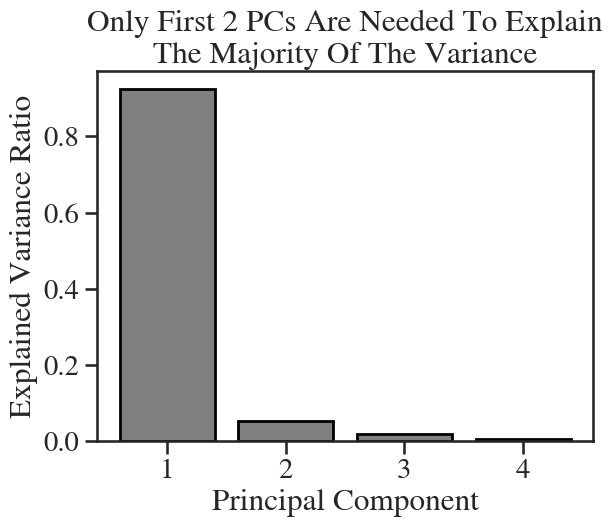

In [21]:
with sns.plotting_context('talk', font_scale=1.25):
    xVals = np.arange(pca_obj.n_components_)+1
    plt.bar(xVals, pca_obj.explained_variance_ratio_, ec='black', lw=2, color='gray')
    plt.title("Only First 2 PCs Are Needed To Explain\nThe Majority Of The Variance")
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(xVals)
    plt.show()

## Simple Pair Plot For Visualization In PC Space

In [22]:
iris_in_pc_space = pca_obj.transform(iris_df[flower_properties])
iris_pc_df = pd.DataFrame.from_dict({col:data for col, data in zip([f'PC_{i}' for i in 1+np.arange(0,pca_obj.n_components_)], iris_in_pc_space.T[:2])})
iris_pc_df['species'] = iris_df['species']
iris_pc_df.head(5)

,PC_1,PC_2,species
0,-1.305903,0.663590,Setosa
1,-1.321074,-0.344500,Setosa
2,-1.405936,-0.279054,Setosa
3,-1.336179,-0.632132,Setosa
4,-1.327497,0.678457,Setosa


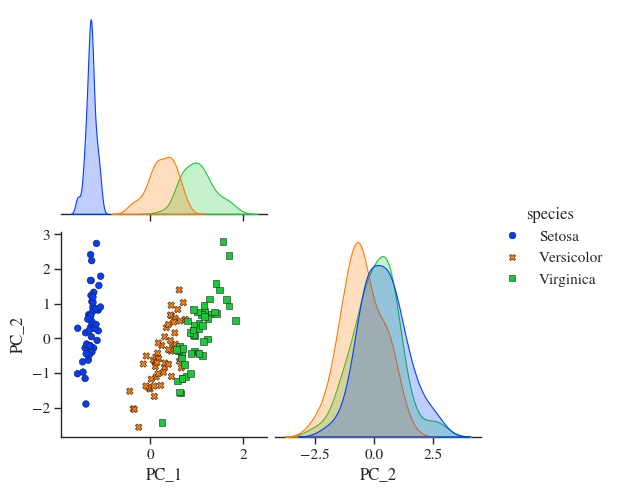

In [23]:
with sns.plotting_context('paper', font_scale=1.25):
    pairGrid = sns.pairplot(data=iris_pc_df, 
                            vars=['PC_1', 'PC_2'],
                            hue='species', 
                            diag_kind='kde', corner=True, 
                            markers=['o', 'X', 's'], plot_kws=dict(ec='k'), palette='bright')
    plt.show()

## Performing A GMM To Separate Species

In [24]:
pc_X_train, pc_X_test, pc_y_train, pc_y_test = train_test_split(iris_pc_df[['PC_1', 'PC_2']], iris_species_encoded, test_size=0.2, random_state=40, shuffle=True)

In [25]:
pc_gmm_obj = GaussianMixture(n_components=3, n_init=10, max_iter=1000, covariance_type='tied').fit(pc_X_train)
pc_gmm_y_train_pred = pc_gmm_obj.predict(pc_X_train)

In [26]:
pc_Xy_train_gmm = pc_X_train.copy()
pc_Xy_train_gmm['clus_lab']=pc_gmm_y_train_pred
pc_Xy_train_gmm['species']=pc_y_train

In [27]:
pc_Xy_test_gmm = pc_X_test.copy()
pc_gmm_y_test_pred = pc_gmm_obj.predict(pc_X_test)
pc_Xy_test_gmm['clus_lab']=pc_gmm_y_test_pred
pc_Xy_test_gmm['species']=pc_y_test

### Visualizing The Results

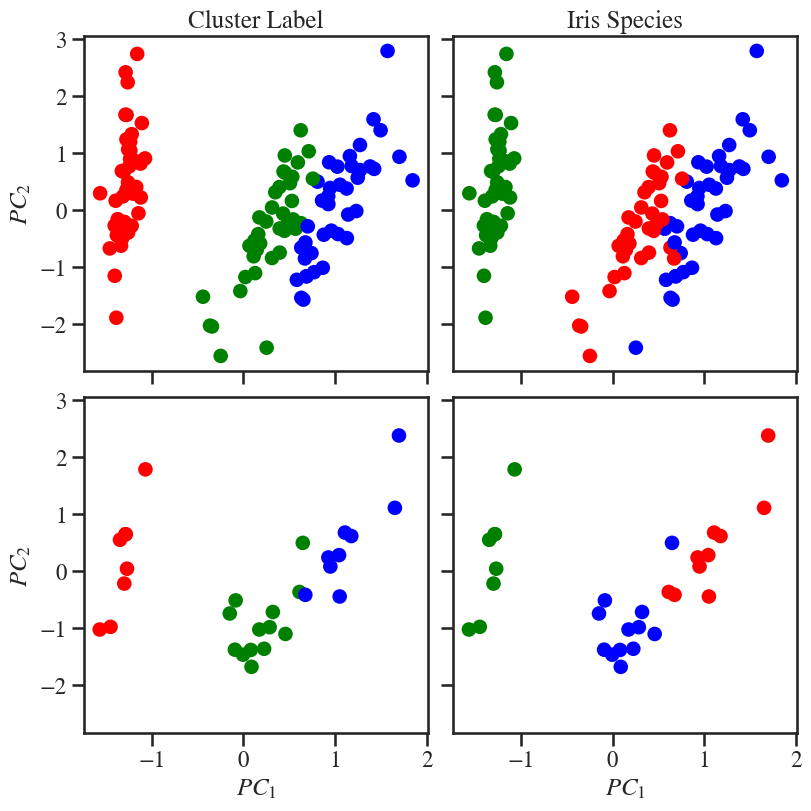

In [28]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(2,2, figsize=[8,8], sharey=True, sharex=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    fAx[0].scatter(pc_Xy_train_gmm['PC_1'], pc_Xy_train_gmm['PC_2'], c=gen_label_colors(pc_Xy_train_gmm['clus_lab']))
    fAx[1].scatter(pc_Xy_train_gmm['PC_1'], pc_Xy_train_gmm['PC_2'], c=gen_label_colors(pc_Xy_train_gmm['species'], colors=['green', 'red', 'blue']))
    
    fAx[2].scatter(pc_Xy_test_gmm['PC_1'], pc_Xy_test_gmm['PC_2'], c=gen_label_colors(pc_Xy_test_gmm['clus_lab']))
    fAx[3].scatter(pc_Xy_test_gmm['PC_1'], pc_Xy_test_gmm['PC_2'], c=gen_label_colors(pc_Xy_test_gmm['species'], colors=['green', 'blue', 'red']))
    
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    fAx[0].set_title('Cluster Label')
    fAx[1].set_title('Iris Species')
    [ax.set_xlabel(r'$PC_1$') for ax in myAx[-1]]
    [ax.set_ylabel(r'$PC_2$') for ax in myAx[:,0]]
    plt.show()

# Using A Random Forest For Classification

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
X_train, X_test, y_train, y_test = train_test_split(iris_features_zscored, iris_species_encoded, test_size=0.4, random_state=40, shuffle=True)

Treating the problem like a standard classification problem, we can use a Random Forest Classifier.

In [42]:
random_forest_obj = RandomForestClassifier()
random_forest_obj.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
Xy_train_rf = X_train.copy()
Xy_train_rf['species'] = y_train
Xy_train_rf['pred-species'] = random_forest_obj.predict(X_train)

Xy_test_rf = X_test.copy()
Xy_test_rf['species'] = y_test
Xy_test_rf['pred-species'] = random_forest_obj.predict(X_test)

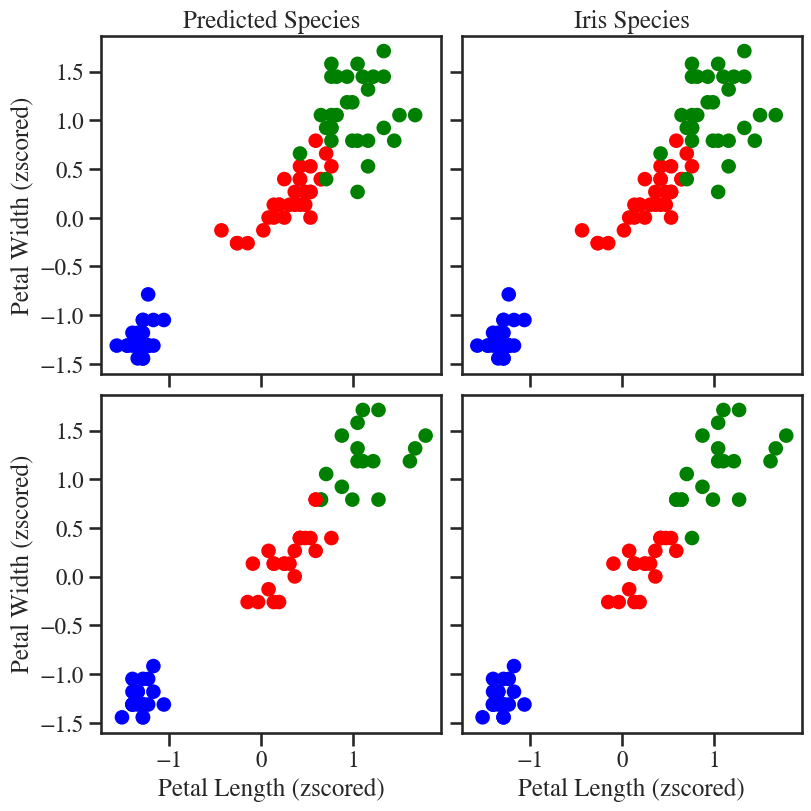

In [44]:
with sns.plotting_context('talk'):
    myFig, myAx = plt.subplots(2,2, figsize=[8,8], sharey=True, sharex=True, constrained_layout=True)
    fAx: list[plt.Axes] = myAx.flatten() if isinstance(myAx, np.ndarray) else np.asarray([myAx])
    fAx[0].scatter(Xy_train_rf['petal_length'], Xy_train_rf['petal_width'], c=gen_label_colors(Xy_train_rf['pred-species']))
    fAx[1].scatter(Xy_train_rf['petal_length'], Xy_train_rf['petal_width'], c=gen_label_colors(Xy_train_rf['species']))
    
    fAx[2].scatter(Xy_test_rf['petal_length'], Xy_test_rf['petal_width'], c=gen_label_colors(Xy_test_rf['pred-species']))
    fAx[3].scatter(Xy_test_rf['petal_length'], Xy_test_rf['petal_width'], c=gen_label_colors(Xy_test_rf['species']))
    
    myHands, myLabs = fAx[0].get_legend_handles_labels()
    if myLabs:
        myFig.legend(myHands, myLabs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    fAx[0].set_title('Predicted Species')
    fAx[1].set_title('Iris Species')
    [ax.set_xlabel(r'Petal Length (zscored)') for ax in myAx[-1]]
    [ax.set_ylabel(r'Petal Width (zscored)') for ax in myAx[:,0]]
    plt.show()

Finally, we see here that not only is the Random Forest classifier performing very well, it is doing so with default settings. Furthermore, we can directly predict the species, rather than get cluster labels, which have the possibility of being permutations of the originally encoded species.